# neu 350 spring 2021<br>week 2: analyzing the crayfish neuromuscular junction

## contents

* [0. preamble](#head)
* [1. loading libraries](#lib)  
* [2. loading abf files](#load)
* [3. getting started](#peak)
* [4. filtering](#filt)
* [5. spike sorting](#sort)
* [6. a few more tricks](#other)
* [7. preparing your figure](#fig)

---

Please report any bugs/problems with this notebook to the [Ed Discussion](https://edstem.org/us/courses/4492/discussion/).  If you have a question about how to do something in python, a good first step is googling it and finding a post that addresses the issue on stackexchange.

<u>Version 2021-02-08.</u> Tested to be compatible with:
* python 3.8.5
* numpy 1.15.4
* matplotlib 3.0.2
* scipy 1.2.0
* jupyter notebook 6.1.6
* pyabf 2.2.8


<a id="head"></a>
## 0. Preamble

This week's experiment features a paired recording, from a motor neuron and the muscle fibers it innervates, in the abdomen of the crayfish.  Your task is to explore these data and report your analysis in a publication-style/-quality figure.  

If you have not already, you should familiarize yourself with the experiment using the materials posted to Canvas.

This notebook is not a flowchart of progressive steps in analysis, and does not represent the scope of analysis we expect you to perform for your first figure.  We would instead encourage you consider the techniques described here as components of a toolbox of techniques from which you make a purposeful choice about what you choose to implement.

If you try to absorb everything here at once it will be overwhelming!  Try to relate the old and new toolsets to the investigation you wish to pursue in generating your figure.  (Some ideas are outlined at the end of the "Crayfish NMJ Introduction" document.)

### Techniques we introduced last week

* <span style="color:magenta">__Peak detection__</span> refers to the identification of the time coordinate and amplitude of spikes or junction potentials. With those coordinates, you are able to perform spike sorting as well as frequency analysis.
* <span style="color:magenta">__Spike sorting__</span> refers to separating your spikes into classes or “units” corresponding to the activity of different individual neurons. (Recall that the crayfish sN3 has 6 dominant axons.) There are many ways to sort.  Last week we demonstrated simple boolean filtering based on an amplitude histogram; below we illustrate more systematic ways to do so.

### Techniques we introduce in this notebook
* Spike sorting by <span style="color:magenta">__k-means clustering__</span> uses an algorithm to geometrically separate points into a number of clusters you define.  We illustrate this approach with k-means clustering because it’s quick and easy. It can be argued that other approaches are better for 1-d data (e.g., natural break segmentation), but we’ll leave that to you to sort out if you become interested. All of these approaches have limitations, first among which is that some of the axons in sN3 have very similar diameters, which makes separating them by amplitude difficult. <span style="color:limegreen"> Note that since you define k, that you must avoid being tautological about what your implementation of k means clustering tells you.</span>  Spikes can also be sorted using __principal component analysis__ (PCA), which is included here for your interest but which we will not explore thoroughly.
* We also introduce <span style="color:magenta">__filtering__</span>, which can be useful to remove slow baseline drift or high frequency noise from your recordings.  For publication, some people are motivated use filtering to produce "pretty" data, but the more rigorous use is to render your data clean _for analysis_.  For example, does slow baseline drift make it difficult to find peaks with an amplitude threshold?  Low pass and high pass filtering can also be used to separate the local field potential from spike trains.  A good description of the use of high and low pass filtering for this purpose is [here 19:10 - 26:34](https://youtu.be/osYGG7TKcz8??version=3&start=1149&end=1585).

<a id="lib"></a>
## 1. Loading Libraries

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as pl
import scipy

!python --version
print("Loaded: numpy ver", np.__version__, ", matplotlib ver", matplotlib.__version__, ", scipy ver", scipy.__version__)

Python 3.8.5
Loaded: numpy ver 1.19.2 , matplotlib ver 3.3.2 , scipy ver 1.5.2


In [2]:
%matplotlib notebook

<a id="load"></a>
## 2. loading .abf files

<span style="color:limegreen">To load [.abf files](https://swharden.com/pyabf/abf2-file-format/) (the output of the digitization hardware & software on our rig computers), we will use a package called `pyabf`.</span>

<div class="alert alert-block alert-warning"> If you have created a separate conda environment for neu350, have you activated this environment before launching jupyter?  The following command will be installing pyabf in whatever environment was active when you launched jupyter.</div>  

In [3]:
# self-installing package loader for pyabf

try:
    import pyabf
except ImportError as e:
    !pip install pyabf
    
import pyabf
print('pyabf', pyabf.__version__, 'loaded')

# if you have problems here, try running the pip command from your terminal instead.

pyabf 2.2.8 loaded


In [4]:
# load multi.abf file and assign its contents to the data structure multichannel_data

data = pyabf.ABF("multi.abf")
#data = pyabf.ABF("21106001.abf")


# what kind of data structure is this?
print(type(data))
print(data)

<class 'pyabf.abf.ABF'>
ABF (version 2.6.0.0) with 2 channels (uV, mV), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 1.01 minutes, recorded without a protocol file.


In [5]:
# this is a complicated data structure.  what's in it?

# Data were collected in two channels.  We need to specify which channel we want to pull data from.

data.setSweep(sweepNumber=0, channel=0) # nerve extracellular recording
nerve_v = data.sweepY
nerve_label = data.sweepLabelY

data.setSweep(sweepNumber=0, channel=1) # muscle intracellular recording
muscle_v = data.sweepY
muscle_label = data.sweepLabelY

times = data.sweepX # time in seconds!  we don't have to worry about the time array

print(nerve_label, nerve_v)
print(muscle_label, muscle_v)
print(times)

Suction (uV) [53.7109 37.8418 10.6812 ...  2.4414 10.376  13.7329]
Membrane Potential (mV) [-830.9937 -830.3833 -830.3833 ... -823.3643 -823.6694 -823.6694]
[ 0.      0.0001  0.0002 ... 60.8253 60.8254 60.8255]


<span style="color:limegreen">For a fuller treatment of the features extracted from the abf file, you can explore the documentation for pyabf [here](https://swharden.com/pyabf/tutorial/).</span>

<a id="plot"></a>
## 3. getting started

<span style="color:limegreen">You pretty much always want to begin by plotting your data.<br><br>See notebook 02.2 to build a function to streamline cycling through a collection of .abf files.</span>

<IPython.core.display.Javascript object>


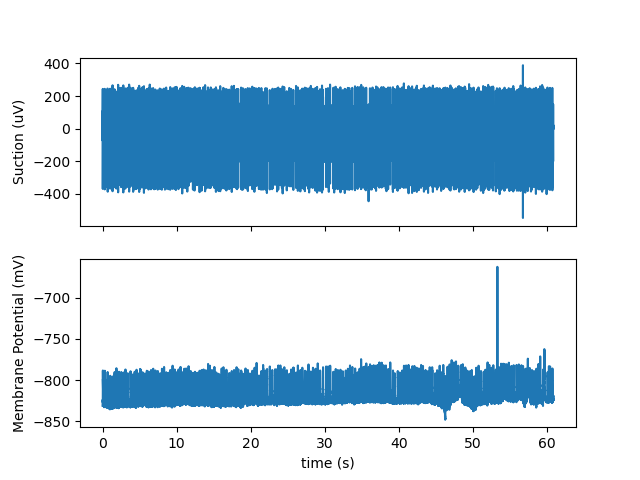

Text(0.5, 0, 'time (s)')

In [6]:
# lets plot the data on a pair of subplots

fig1,(ax1a,ax1b) = pl.subplots(2,1, num=1, sharex=True)
                                          #^^^^^^^^^^^ when we zoom on one plot, it'll scale both
ax1a.plot(times, nerve_v)
ax1a.set_ylabel(nerve_label)

ax1b.plot(times, muscle_v) # the muscle voltage is actually scaled incorrectly here
ax1b.set_ylabel(muscle_label)

ax1b.set_xlabel("time (s)")

<IPython.core.display.Javascript object>


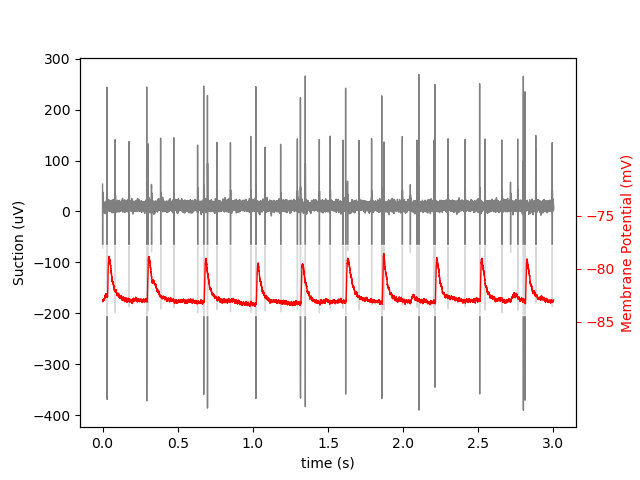

In [7]:
# you could also plot both traces on a single plot.
# just be careful not to make things to visually busy.

#let's crop the data first

nerve_crop = nerve_v[0:30000]
muscle_crop = muscle_v[0:30000] /10 # let's fix that scaling error, too.  (DON'T DO THIS WITH GOOD DATA!)
time_crop = times[0:30000]

fig2,ax2a = pl.subplots(num=2)
ax2a.plot(time_crop, nerve_crop, color='gray', lw=1)
ax2a.set_ylabel(nerve_label)
ax2a.set_xlabel('time (s)')

ax2b = ax2a.twinx()
ax2b.plot(time_crop, muscle_crop, color='red', lw=1)
ax2b.set_ylabel(muscle_label);

In [8]:
# Certainly starts out kind of busy.  Let's clean it up.
# 1: rescale the 2nd y axis.  I chose these manually -- you will need to adapt to real data.

ax2b.set_ylim(-95,-60);  

In [9]:
# 2: tidy up tick marks (cf. Tufte)

ax2b.set_yticks([-75,-80,-85])
ax2b.yaxis.label.set_color('red')
ax2b.tick_params(axis='y', colors='red'); #the semicolon here just suppresses unnecessary output.  (remove it to see)

In [10]:
# 3: let's make things prettier by putting a transparent box behind the muscle trace.

box_bottom = np.min(muscle_crop)*1.01
box_height = np.max(muscle_crop)*0.99 - box_bottom
box_min = np.min(time_crop)-0.1
box_width = np.max(time_crop)*0.99 - np.min(time_crop)+0.2

musclebox = matplotlib.patches.Rectangle((box_min,box_bottom), box_width, box_height, color="w", alpha=0.7, edgecolor=None)
ax2b.add_patch(musclebox);

<a id="filt"></a>
## 4. filtering

<span style="color:limegreen">The data we aquire is generally filtered at the hardware level.  Nonetheless, it would sometimes be helpful to do some filtering when you observe a slow drift in signal baseline, particularly if it varies in a way that makes peak detection unreliable.  I would only complete this step when it necessary, since it is both time/processor intensive and introduces distortion.  Zoom in on the signal below.  You will notice that the slow drift has been eliminated, but that the amplitudes of the JPs has changed.  Generally you should refer back to the unfiltered data for any measures that depend on the amplitudes of events like spikes or JPs rather than just their timing. </span>

<IPython.core.display.Javascript object>


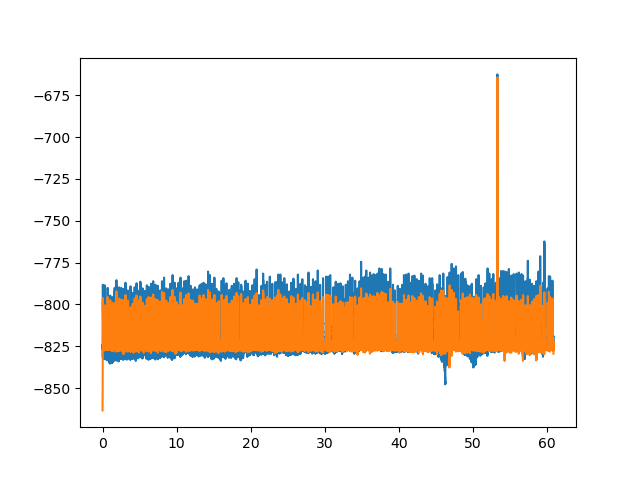

In [11]:
from scipy.signal import medfilt


fig3,ax3 = pl.subplots(num=3)
ax3.plot(times, muscle_v)
correction = medfilt(muscle_v, kernel_size=801)
muscle_filt = muscle_v - correction + np.median(muscle_v)
ax3.plot(times, muscle_filt)

<a id="sort"></a>
## 5. spike sorting

<span style="color:limegreen">  The input to spike sorting as outlined below are arrays of `peaks` and `peak_heights` (as we created last week).  We will leave to you to generate these arrays.<br><br> When you implement `find_peaks`, you should be careful to set the height and distance parameters such that no spurious peaks are called.  (Zoom in and look at 3 seconds rather than 60.) <br><br>If you find you need to apply spike sorting to the muscle recording, you will need yet different parameters: note the very different shapes of peaks in the figures above -- an amplitude threshold may not be the right starting point there.</span>

<IPython.core.display.Javascript object>


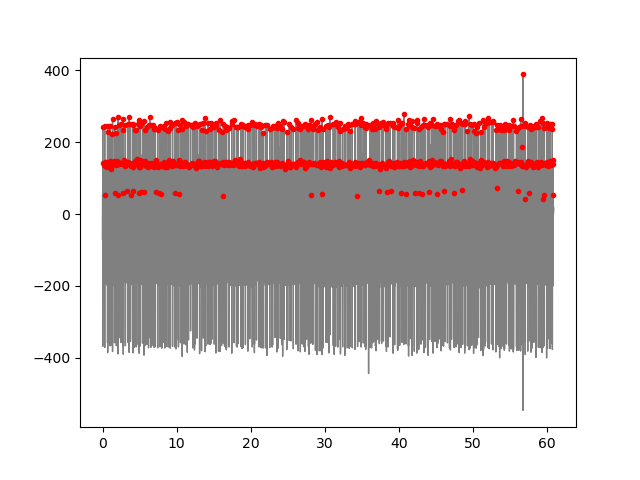

In [12]:
from scipy.signal import find_peaks

thresh = 
dist = 

peaks,_ = find_peaks(nerve_v, height=thresh, distance = dist)    

peak_heights = nerve_v[peaks]

fig4, ax4 = pl.subplots(num=4)
ax4.plot(times, nerve_v, color="gray", lw=1)
ax4.plot(times[peaks], peak_heights, 'r.')

<IPython.core.display.Javascript object>


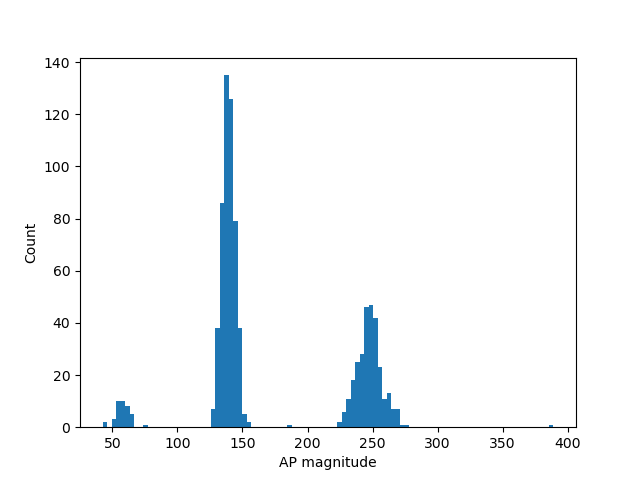

Text(0, 0.5, 'Count')

In [13]:
# display the distribution of peak values (to help you select the value for k)

fig5, ax5 = pl.subplots(num=5)
ax5.hist(peak_heights, bins=100)
pl.xlabel('AP magnitude')
pl.ylabel('Count')

In [14]:
# k-means clustering

from sklearn.cluster import KMeans

k = 5



# reshape the data to the shape (n_samples, n_features) -- required for scikit-learn
X = peak_heights.reshape([-1,1])

# run k-means clustering
km = KMeans(n_clusters=k).fit(X)

print(km)
print(km.labels_)

KMeans(n_clusters=5)
[1 0 0 ... 0 2 0]


<span style="color:limegreen">Can you make sense of the output?  If not, how could you interrogate the function to do so?</span>

<IPython.core.display.Javascript object>


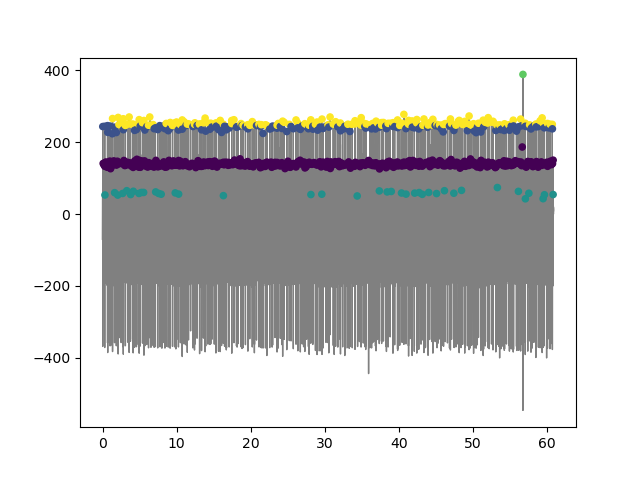

In [15]:
# display the nerve and the peaks colored by cluster

fig6, ax6 = pl.subplots(num=6)

ax6.plot(times,nerve_v, color="gray", lw=1) #raw data

peak_times = times[peaks]

ax6.scatter(peak_times, peak_heights, c=km.labels_, s=20, zorder=10)


<div class="alert alert-block alert-info">

**How can you assess the quality of your clustering?**  You could calculate a [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), which will tell you how well the clusters are separated for different values of k.  However, this *does not account for the confound* that some of the axons (of similar diameter) will have very similar amplitudes (i.e., peak amplitudes of sN3 are not distributed in evenly spaced clusters, which would be the preferred input to k-means clustering).  
    
You will need to judge the clustering yourself. Sometimes multiple classes simply can't be separated algorithmically -- this is an okay outcome!  But it is preferable that you notice...  One clue that you have multiple classes that aren't separated is that a designated class of spikes is only associated with a subsequent JP part of the time (there should be a 1:1 correspondence). </div>


<span style="color:limegreen">You could use PCA instead of amplitude as the basis of cluster separation.  (You would still subsequently cluster your spike classes, just in the multi-dimensional space of principal components instead of the 1-d space of amplitudes.  **This is almost certainly outside the scope of your first figure!**</span>

<IPython.core.display.Javascript object>


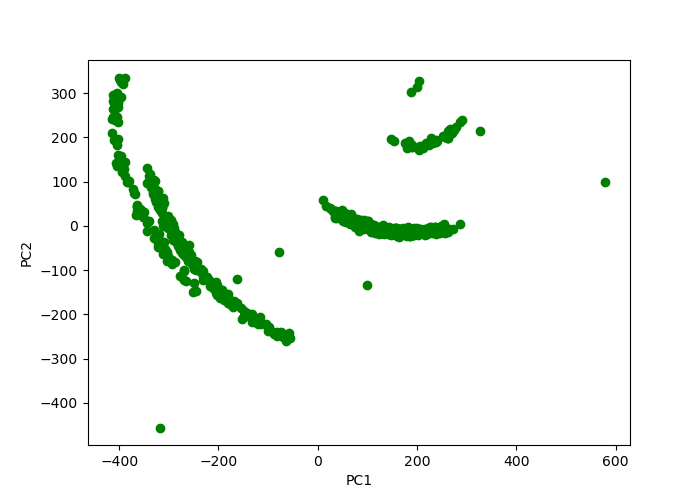

Text(0, 0.5, 'PC2')

In [28]:
# PCA

# for PCA the input is the waveform of each spike.

waveforms = []
for peak in peaks:
    if(peak>=20 and peak<=len(nerve_v)-30): #edge cases ignored
        waveforms.append(nerve_v[peak-20:peak+30])
    
M = np.array(waveforms)

covariance_matrix=np.cov(M.T) ### calculating the covariance matrix
U, S, VT = np.linalg.svd(covariance_matrix) ### svd of covaraince matrix

# cumulative_variance_explained=np.cumsum(S)/np.sum(S)
# fig,ax=pl.subplots(figsize=(8, 6))
# pl.plot(np.arange(0,np.shape(S)[0],1),cumulative_variance_explained*100,'-or')
# pl.xlabel('Number of Principal Components',fontsize=16)
# pl.ylabel('Percentage variance explained',fontsize=16)
# pl.title('Variance explained by different PCs')
# pl.tick_params(labelsize=16)  

Mo=M-np.mean(M,axis=0) 

projection_on_PC1=np.dot(Mo,U[:,0])
projection_on_PC2=np.dot(Mo,U[:,1])

fig7,ax7 = pl.subplots(figsize=(7,5),num=7)
ax7.plot(projection_on_PC1,projection_on_PC2,'og')
ax7.set_xlabel('PC1')
ax7.set_ylabel('PC2')
# pl.tick_params(labelsize=12) 

<IPython.core.display.Javascript object>


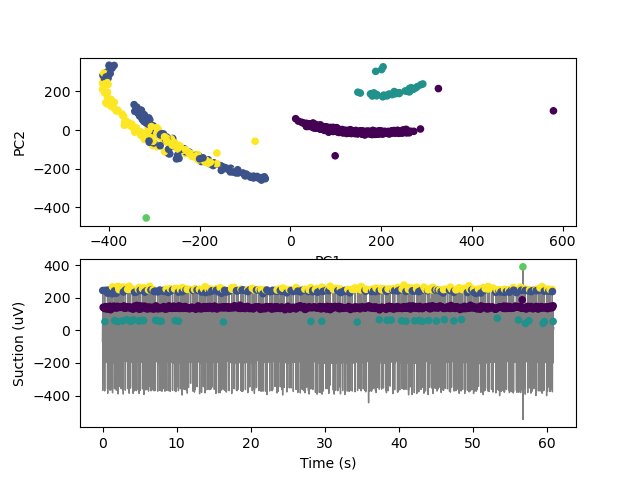

Text(0.5, 0, 'Time (s)')

In [20]:
# now apply k-means clustering in 2d

pc_k = 5

# input is a transposed array of our two PCs
pc_X = np.array([projection_on_PC1,projection_on_PC2]).T

# run k-means clustering
pca_km = KMeans(n_clusters=k).fit(X)

fig9,(ax9a,ax9b) = pl.subplots(2,1, num=9)

ax9a.scatter(projection_on_PC1, projection_on_PC2, c=pca_km.labels_, s=20, zorder=10)
ax9a.set_xlabel('PC1')
ax9a.set_ylabel('PC2')

ax9b.plot(times,nerve_v, color="gray", lw=1) #raw data
ax9b.scatter(peak_times, peak_heights, c=pca_km.labels_, s=20, zorder=10)
ax9b.set_ylabel(nerve_label)
ax9b.set_xlabel('Time (s)')

# when I look at the sample data output, I think there may actually be two clusters in the lower left 
# of the PCA space that k-means is having trouble separating!

# also note that the results can change each time you run the PCA!

<a id="other"></a>
## 6. a few more tricks

<IPython.core.display.Javascript object>


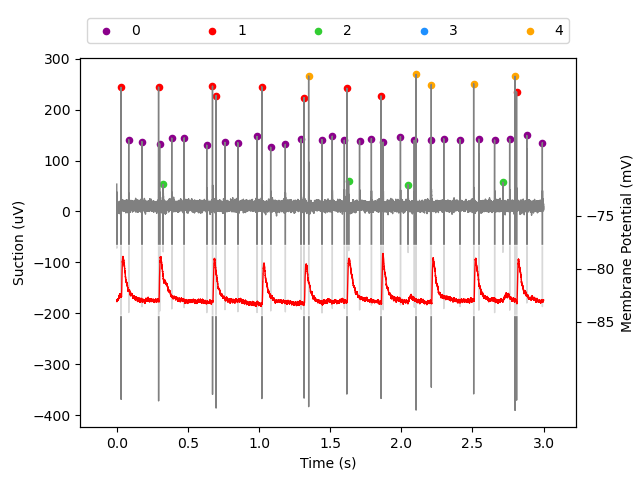

In [23]:
# a slightly fancier display version of figure 6

fig8, ax8 = pl.subplots(num=8)
label_list = km.labels_.tolist()

# I want a collection of colors I can refer back to later
colorlist = {0: 'darkmagenta', 1: 'red', 2: 'limegreen', 3: 'dodgerblue', 4: 'orange'}

# sorted peaks
for i in range(len(peak_times)):
    if peaks[i] <30000:
        ax8.scatter(peak_times[i], peak_heights[i], c=colorlist[label_list[i]], label="class {}".format(label_list[i]), s=20)

# nerve trace    
ax8.plot(time_crop, nerve_crop, color="gray", lw=1) 
# ax8.set_ylabel()
ax8.set_xlabel('Time (s)')
ax8.set_ylabel(nerve_label)


# muscle trace
ax8a = ax8.twinx()
ax8a.plot(time_crop, muscle_crop, color='red', lw=1)
# ax8a.set_ylabel()
ax8a.set_ylim(-95,-60)
ax8a.set_yticks([-75,-80,-85])
ax8a.set_ylabel(muscle_label);


# shade behind muscle trace
musclebox = matplotlib.patches.Rectangle((box_min,box_bottom), box_width, box_height, color="w", alpha=0.7, edgecolor=None)
ax8a.add_patch(musclebox);

# legend
legend=[0,0,0,0,0]

for i in range(5):
    legend[i]=ax8.scatter([], [], c=colorlist[i], label=i, s=20, zorder=10)
ax8.legend(handles=legend, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=5, mode="expand");

<IPython.core.display.Javascript object>


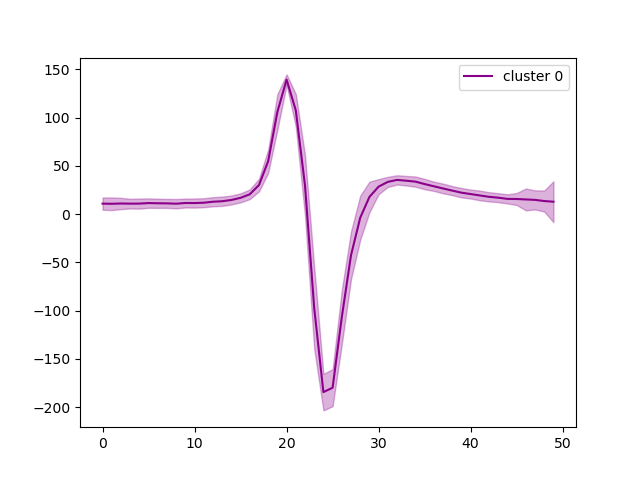

In [27]:
# plotting an average waveform for one cluster

# step 1: pull out waveform of an arbitrary cluster
cluster = 0

waveforms = []
for i,peak in enumerate(peaks):
    if(km.labels_[i]==cluster):
        if(peak>=20 and peak<=len(nerve_v)-30): #edge cases ignored
            waveforms.append(nerve_v[peak-20:peak+30])
    
waveform_ary = np.array(waveforms)

# step 2: plot average waveform
fig10,ax10 = pl.subplots(num=10)
trace = ax10.plot(waveform_ary.mean(axis=0), color=colorlist[cluster], 
                  label="cluster {}".format(cluster))
ax10.legend()


# step 3: plot a set of extremities for the waveform (min/max, SEM, or std dev)
ax10.fill_between(range(waveform_ary.shape[1]),
                  waveform_ary.mean(axis=0)-waveform_ary.std(axis=0),
                  waveform_ary.mean(axis=0)+waveform_ary.std(axis=0),
                  color=colorlist[cluster], alpha=0.3)

In [ ]:
# idea: plotting the spike raster instead of dots at peak_heights

<a id="fig"></a>
## 7. preparing your figure

Here is some advice concerning the preparation of your figure:

* The first panel should usually be a raw data trace.  If one of your panels includes a raw data trace (e.g. you're plotting dots to mark detected spikes), that counts.
* This notebook describes analytical techniques rather than strategies for communicating them.  Among many things to consider is what range of data to include in each figure/panel.  The default zoom of, say, figure 6 shows data that are way too dense for a reader to make meaningful interpretations of the analysis.  Compare this to the various traces that show 6 seconds instead of 60.  Even though the whole recording should be the input to your analysis, your figure is a _summary_ of your analysis rather than a presentation of every data point.
* On the other hand, if data are not too dense, it can sometimes be better to show all the data than summary data.  You can decrease the visual density by plotted in muted colors or low transparency.  Refer to the Tufte readings for advice best practices for visual communication. 